In [1]:
#pip install num2words

In [2]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from string import punctuation
from lxml import etree
from collections import defaultdict, Counter
#from num2words import num2words
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
import timeit

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def conv_html(col):
    """
    Fonction de convertion de html en chaine standard
    """

    html = BeautifulSoup(col, 'html.parser')
    # Delete url strings
    for t in html.find_all('a'):
        t.replace_with('')
    # Delete code blocks
    for t in html.find_all('pre'):
        t.replace_with('')
    
    return html.get_text(' ', strip=True)

def clean_field(col, tknzr, sw, lmtzr, stmr):
    """
    Fonction de tokenisation du contenu dont regex \w+, 
    suppression des stopwords, lemmatisation et racinisation
    """

    return ' '.join([stmr.stem(lmtzr.lemmatize(w, get_wordnet_pos(w))) \
                     for w in tknzr.tokenize(col) \
                     if w not in list(sw) and w.isalpha()])

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Chargement

In [5]:
freq = defaultdict()

train = pd.read_csv("db_StackOverflow.csv", header=0, encoding='utf-8',\
                    delimiter=',', quotechar='"', index_col=0, )
train.rename_axis(None, inplace=True)
train = train.apply(lambda x: x.astype(str).str.lower())
cols = train.columns

print(train.info())

for col in cols:
    freq[col] = Counter(' '.join(train_1T[col].values).split()).most_common()
    print('{} mots dans "{}" dont {} distincts'.\
          format(sum(dict(freq[col]).values()), col, len(freq[col])))

train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 169828 to 1669645
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   50000 non-null  object
 1   Body    50000 non-null  object
 2   Tags    50000 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB
None
428719 mots dans les titres dont 37241 distincts, 
6055132/561841 dans les détails, 
50000/37101 dans les tags


,Title,Body,Tags
169828,what are the real benefits of visual studio te...,<p>interested if anyone has used vsts database...,<sql-server><database-tools>
431644,how can i hook into the current formsauthentic...,<p>i've got an httpmodule in my application th...,<asp.net><events><forms-authentication><httpmo...
1450121,is there any sync algorithm/reference availabl...,<p>i'm planning to write a program to sync a f...,<algorithm><synchronization>
426609,how to assign profile values?,"<p>i don't know what i am missing, but i added...",<asp.net><asp.net-mvc><asp.net-membership><pro...
14646,"how to add ""project description"" in fogbugz?",<p>when i create a new project (or even when i...,<fogbugz>


# Nettoyage du dataframe

In [6]:
# Stopwords nltk 
sw_std = set(nltk.corpus.stopwords.words('english')) 

tokenizer = nltk.RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

print('='*30)
for col in ['Title', 'Body']:
    if col == 'Body':
        # Convertion du html en chaine standard 
        print('Conversion html de "{}" '.format(col), end='')
        start_time = timeit.default_timer()
        train[col] = train[col].apply(conv_html)
        elapsed = timeit.default_timer() - start_time
        print('-> OK en {:.3} sec'.format(elapsed))

    # Tokenisation et suppression des stopwords
    print('Nettoyage/lemmatisation de "{}" '.format(col), end='')
    start_time = timeit.default_timer()
    train[col] = train[col].apply(clean_field, tknzr=tokenizer, \
                                  sw=sw_std, lmtzr=lemmatizer, stmr=stemmer)
    elapsed = timeit.default_timer() - start_time
    print('-> OK en {:.3} sec'.format(elapsed))

# Reformatage des tags
print('Traitement des tags ', end='')
start_time = timeit.default_timer()
# Ajout du nombre de Tags 
train['nTags'] = train['Tags'].apply(lambda x: len(x.split('><')))
train['Tags'] = train['Tags'].apply(lambda x: ' '.join(x[1:-1].split('><')))
elapsed = timeit.default_timer() - start_time
print('-> OK en {:.3} sec'.format(elapsed))

print('='*30)
for col in cols:
    freq[col] = Counter(' '.join(train_1T[col].values).split()).most_common()
    print('{} mots dans "{}" dont {} distincts'.\
            format(sum(dict(freq[col]).values()), col, len(freq[col])))

train.head()

Nettoyage/lemmatisation de "Title" -> OK en 53.7 sec
Conversion html de "Body" -> OK en 20.1 sec
Nettoyage/lemmatisation de "Body" -> OK en 4.26e+02 sec
Traitement des tags -> OK en 0.0699 sec
274364 mots dans les titres dont 12604 distincts, 
2311819/42566 dans les détails, 
145824/10494 dans les tags


,Title,Body,Tags,nTags
169828,real benefit visual studio team system databas...,interest anyon use vst databas edit extens fea...,sql-server database-tools,2
431644,hook current formsauthenticationmodul medium t...,get httpmodul applic hook formsauthenticationm...,asp.net events forms-authentication httpmodule...,5
1450121,sync algorithm refer avail sync directori,plan write program sync folder real time acros...,algorithm synchronization,2
426609,assign profil valu,know miss add profil properti web config file ...,asp.net asp.net-mvc asp.net-membership profile,4
14646,add project descript fogbugz,creat new project even edit sampl project way ...,fogbugz,1


## Explorations des tags

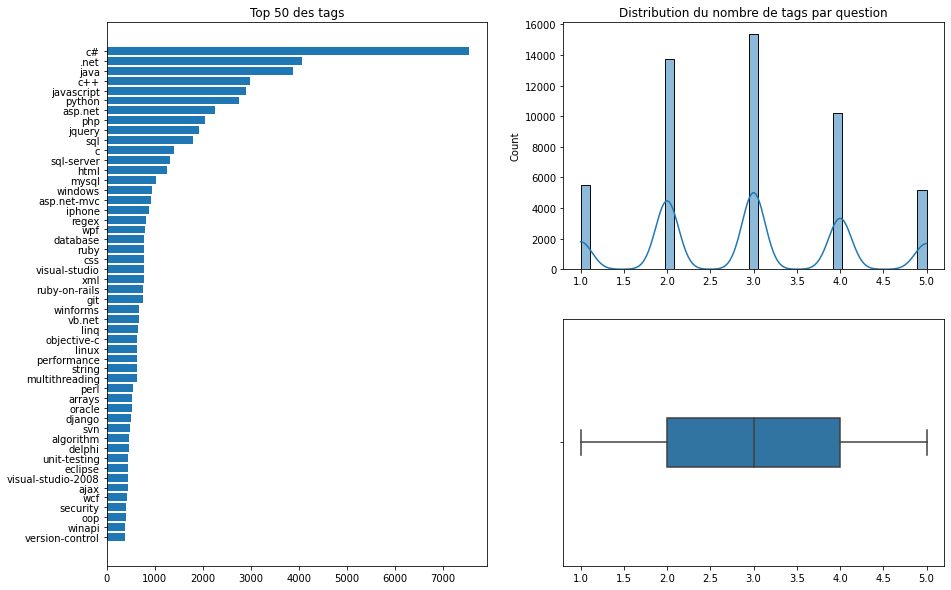

In [7]:
top = 50

fig = plt.figure(1, figsize=(15, 10))
plt.subplot(121)
plt.barh([k for k, v in sorted(freq['Tags'][:top], key=lambda x: x[1])], 
         [v for k, v in sorted(freq['Tags'][:top], key=lambda x: x[1])])
plt.title('Top {} des tags'.format(top))
plt.subplot(222)
plt.title('Distribution du nombre de tags par question')
sns.histplot(train['Tags'].apply(lambda x: len(x.split())).values, kde=True)
plt.subplot(224)
sns.boxplot(x=train['Tags'].apply(lambda x: len(x.split())).values, width=0.2)

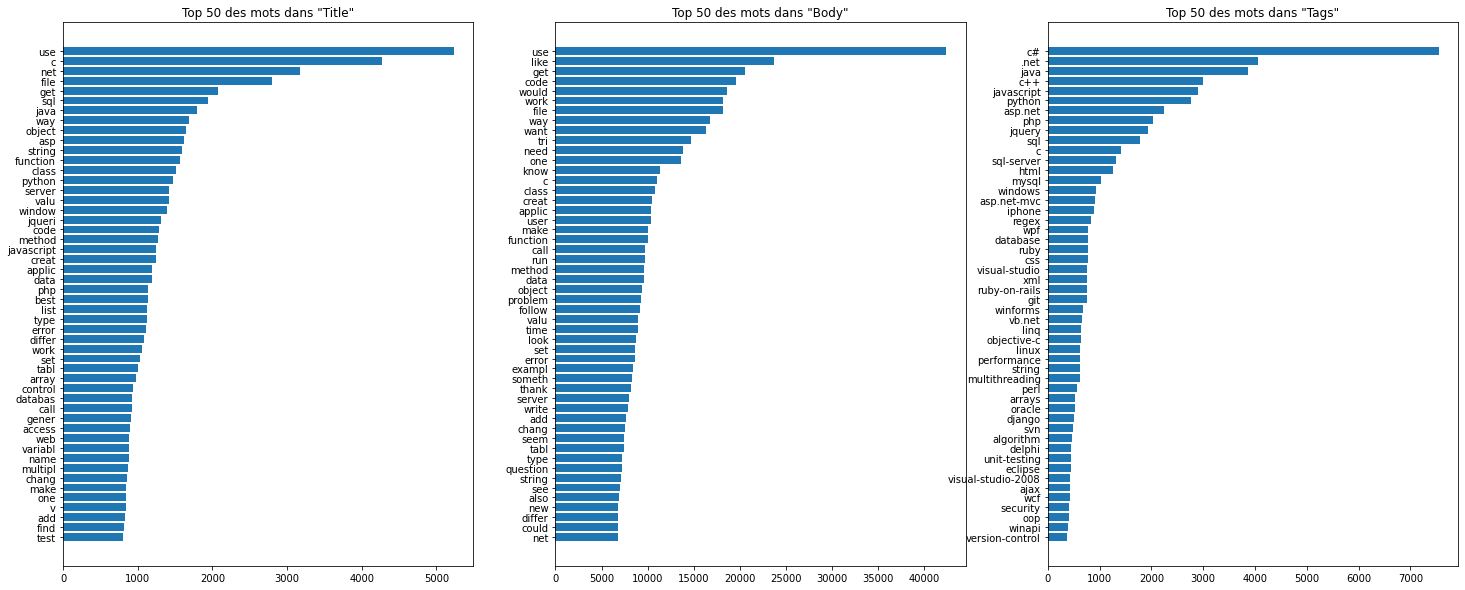

274364 mots dans les titres dont 12604 distincts, 
2311819/42566 dans les détails, 
145824/10494 dans les tags


In [8]:
cpt = 1
fig = plt.figure(1, figsize=(25, 10))

for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq[col][:top], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:top], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(top, col))
    cpt += 1 
plt.show() 

## Extra stopwords
J'enlève les radicaux qui ne me semblent pas discriminants (ex. use, ...)

262606 mots dans "Title" dont 12594 distincts
2131019 mots dans "Body" dont 42556 distincts


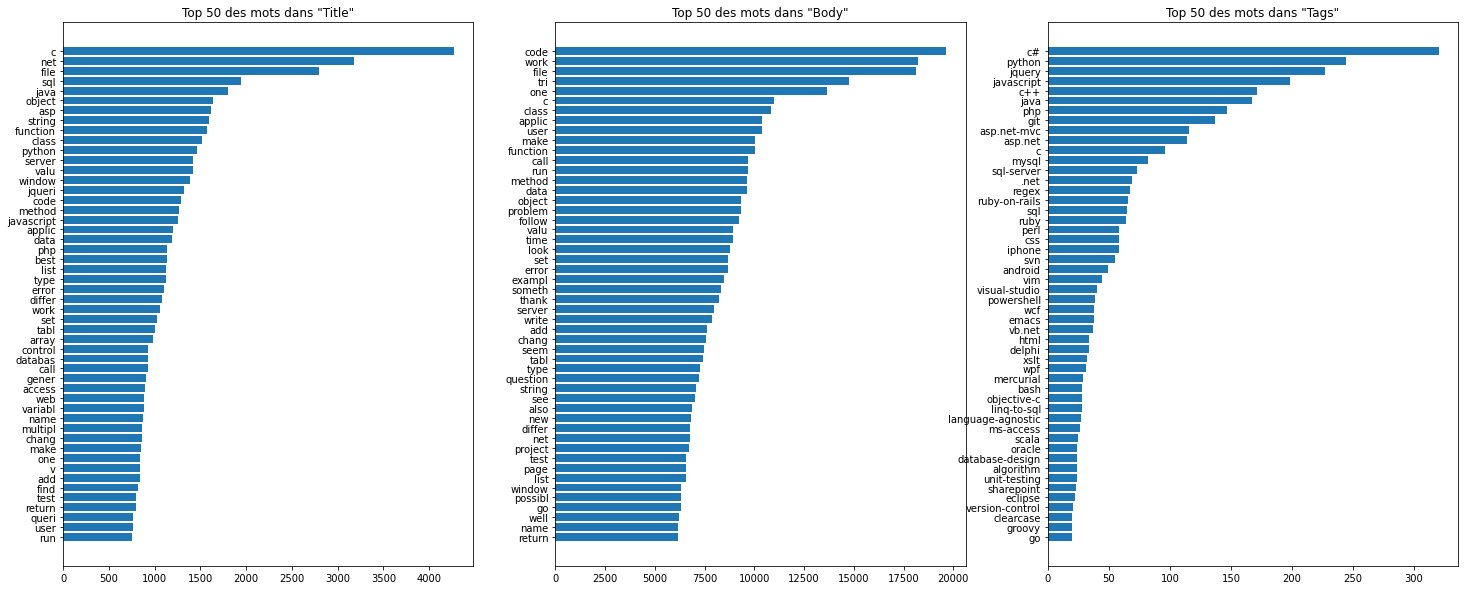

In [19]:
extra_sw = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need', 'know', 'could') 
cpt = 1

for col in  ['Title', 'Body']:
    train[col] = train[col].apply(lambda x: ' '.join([w for w in x.split() if w not in extra_sw]))
    freq[col] = Counter(' '.join(train[col].values).split()).most_common()
    print('{} mots dans "{}" dont {} distincts'.\
        format(sum(dict(freq[col]).values()), col, len(freq[col])))
print('='*30)

fig = plt.figure(1, figsize=(25, 10))

for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq[col][:top], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:top], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(top, col))
    cpt += 1 

# Réduction du scope
Pour commencer, je considère les questions avec 1 seul tag 

In [20]:
train_1T = train[train.nTags == 1]

for col in cols:
    freq[col] = Counter(' '.join(train_1T[col].values).split()).most_common()
    print('{} mots dans "{}" dont {} distincts'.\
            format(sum(dict(freq[col]).values()), col, len(freq[col])))

train_1T.head()

27707 mots dans "Title" dont 3755 distincts
191038 mots dans "Body" dont 9821 distincts
5512 mots dans "Tags" dont 867 distincts


,Title,Body,Tags,nTags
14646,add project descript fogbugz,new project even edit sampl project add descri...,fogbugz,1
34017938,decrement valu scheme,procedur find n small prime larg add paramet n...,scheme,1
1023055,sort current point end file gvim,follow command mode gvim result star littl som...,vim,1
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1


Réduction aux 50 top tags

In [ ]:
questions = []
bodies = []
tags = []
cpt = 0
lst = []

for i, j in source.items():
    res = [x for x in j[2] if x not in tags_top.keys()]
    if res:
        lst.append(i) 
    else:
        questions.extend(j[0])
        bodies.extend(j[1])
        tags.extend(j[2])
        cpt += 1 

for i in lst: 
    del source[i]        

freq['questions'] = Counter(questions).most_common() 
freq['bodies'] = Counter(bodies).most_common()
freq['tags'] = Counter(tags).most_common()

print('{} questions'.format(cpt))
print('{:6d} mots dans les titres\n{:6d}\t\t les détails \n{:6d}\t\t les tags'.\
format( len(freq['questions']), len(freq['bodies']), len(freq['tags'])))

3481 questions
  3922 mots dans les titres
 11667		 les détails 
    50		 les tags


Text(0.5, 1.0, 'Top 30 des mots significatifs (>4 car.) dans les détails')

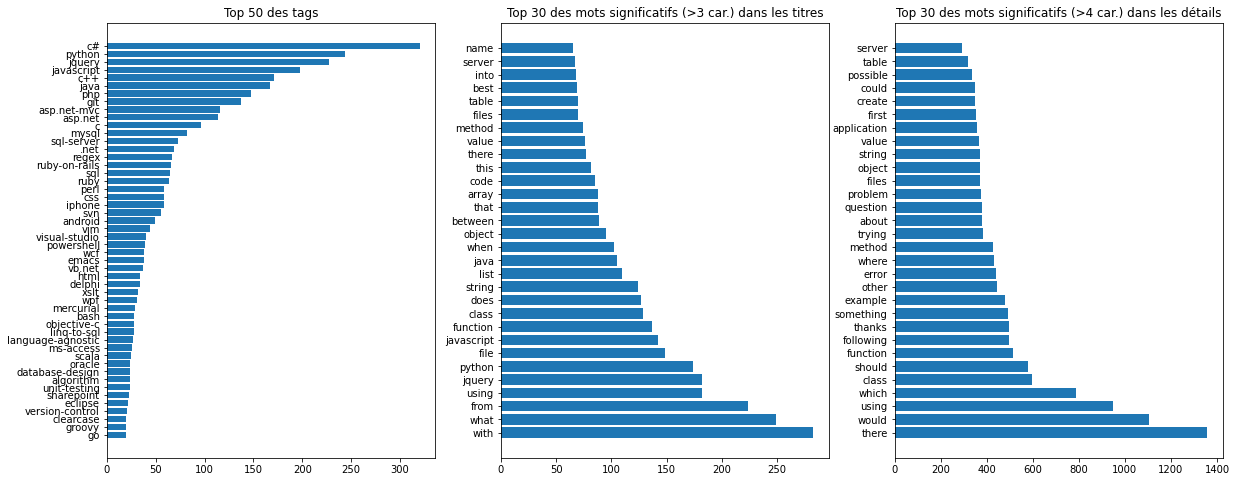

In [ ]:
fig = plt.figure(1, figsize=(20, 8))
plt.subplot(131)
plt.barh([k for k, v in sorted(freq['tags'], key=lambda x: x[1])], 
         [v for k, v in sorted(freq['tags'], key=lambda x: x[1])])
plt.title('Top {} des tags'.format(top))

fig = plt.figure(1, figsize=(15, 8))
plt.subplot(132)
temp = {k: n for k, n in freq['questions'] if len(k)>3}
temp = sorted(temp.items(), key=lambda t: t[1], reverse=True)[:top2]
plt.barh([k for k, v in temp], [v for k, v in temp])
plt.title('Top {} des mots significatifs (>3 car.) dans les titres'.format(top2))

plt.subplot(133)
temp = {k: n for k, n in freq['bodies'] if len(k)>4}
temp = sorted(temp.items(), key=lambda t: t[1], reverse=True)[:top2]
plt.barh([k for k, v in temp], [v for k, v in temp])
plt.title('Top {} des mots significatifs (>4 car.) dans les détails'.format(top2))

Justifier le split des sw à 10%

In [ ]:
#questions
cpt = 0
for w, c in freq['questions']:
    if c >= len(freq['questions']) * .1:
        sw.update(w)
        cpt += 1
print('{} stopwords dont {} dans les questions'.format(len(sw), cpt))

cpt = 0
for w, c in freq['bodies']:
    if c >= len(freq['bodies']) * .1:
        sw.update(w)
        cpt += 1
print('{} stopwords dont {} dans les bodies'.format(len(sw), cpt))

184 stopwords dont 7 dans les questions
191 stopwords dont 34 dans les bodies


# Lemmatisation/racinisation et préparation des TF/IDF

Avec la lemmatisaton sans racinisation, des mots comme absolute/absolutely, abstract/abstraction ne sont pas groupés (cf. ci-dessous)

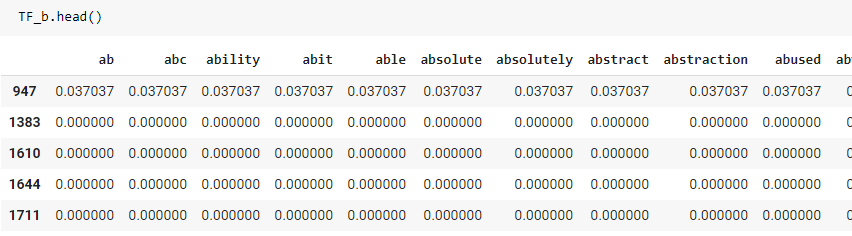

In [ ]:
def stemnlem(tokens, stopwords, stemr, lemr):
    temp = [] 
    for w in tokens:
        if w.isalpha() and w not in stopwords:
            temp.append(stemr.stem(lemr.lemmatize(w)))
    return temp, len(temp)

corpus = []
corpus_q = []
corpus_b = []
dict_TF_q = defaultdict(dict)
dict_TF_b = defaultdict(dict)

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

for i, text in source.items():
    temp = []
    title, n = stemnlem(text[0], sw, stemmer, lemmatizer)
    detail, m = stemnlem(text[1], sw, stemmer, lemmatizer)
    source[i][0] = title
    source[i][1] = detail
    temp.extend(title)
#    temp.extend(detail)
    corpus.extend(temp)
    freq = Counter(temp)
    for w in title:
        dict_TF_q[i][w] = freq[w] / (n + m)
#    for w in detail:
#        dict_TF_b[i][w] = freq[w] / (n + m)

dict_corpus = Counter(corpus)

## Term Frequencies (TF)

In [ ]:
TF_q = pd.DataFrame(dict_TF_q).fillna(0).T
TF_b = pd.DataFrame(dict_TF_b).fillna(0).T
TF_q.shape, TF_b.shape

((3476, 2571), (0, 0))

In [ ]:
TF_q.columns = TF_q.columns.sort_values()
TF_b.columns = TF_b.columns.sort_values()
TF_q.head()

,aa,aarrggbb,abandon,abbrevi,abl,absolut,abstract,abus,academ,acc,acceleromet,accept,access,accessor,accident,accord,accoss,account,accountcontrol,accross,accumul,acid,across,action,actioncontrol,actionlink,actionresult,actionsheet,activ,activerecord,activex,actual,ad,add,addday,address,addslash,adjust,admin,advanc,...,worker,world,worri,wors,worth,would,wpf,wrap,writabl,write,writeabl,writefil,writeln,written,wrong,wysiwyg,x,xhtml,xml,xp,xsd,xsl,xslt,xsltproc,xx,xxx,xyz,ye,year,yet,yield,yyyi,z,zcat,zehut,zero,zip,ziparch,zoom,ß
1023055,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.0,0.0,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2177008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.2,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.008130,0.00813,0.00813,0.00813,0.00813,0.00813,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.021277,0.00000,0.00000,0.00000,0.00000,0.00000,0.021277,0.021277,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.016129,0.016129,0.032258,0.016129,0.016129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
TF_b.head()

""


## IDF

In [ ]:
dict_IDF_q = defaultdict(dict)
dict_IDF_b = defaultdict(dict)

for i, text in source.items():
    for w in text[0]:
        dict_IDF_q[i][w] = np.log(N / dict_corpus[w])
#    for w in text[1]:
#        dict_IDF_b[i][w] = np.log(N / dict_corpus[w])

IDF_q = pd.DataFrame(dict_IDF_q).fillna(0).T
IDF_b = pd.DataFrame(dict_IDF_b).fillna(0).T
IDF_q.columns = IDF_q.columns.sort_values()
IDF_b.columns = IDF_b.columns.sort_values()
IDF_q.shape, IDF_b.shape

((3476, 2571), (0, 0))

In [ ]:
IDF_q.head()

,aa,aarrggbb,abandon,abbrevi,abl,absolut,abstract,abus,academ,acc,acceleromet,accept,access,accessor,accident,accord,accoss,account,accountcontrol,accross,accumul,acid,across,action,actioncontrol,actionlink,actionresult,actionsheet,activ,activerecord,activex,actual,ad,add,addday,address,addslash,adjust,admin,advanc,...,worker,world,worri,wors,worth,would,wpf,wrap,writabl,write,writeabl,writefil,writeln,written,wrong,wysiwyg,x,xhtml,xml,xp,xsd,xsl,xslt,xsltproc,xx,xxx,xyz,ye,year,yet,yield,yyyi,z,zcat,zehut,zero,zip,ziparch,zoom,ß
1023055,7.728736,7.561682,7.986565,7.641724,5.430707,9.721166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2177008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.561682,6.849486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.863951,6.557098,10.819778,10.819778,5.536575,8.622554,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.863951,0.000000,0.000000,0.000000,0.000000,0.000000,6.489045,8.517193,5.106045,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.615772,9.21034,7.824046,7.035589,7.487574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
IDF_b.head()

""


# TF-IDF

### Focus Titres

In [ ]:
dict_TFIDF_q = defaultdict(dict)
dict_TFIDF = defaultdict(dict)

for i, v in dict_TF_q.items():
    for w, c in v.items():
        dict_TFIDF_q[i][w] = c * dict_IDF_q[i][w]

dict_TFIDF = dict_TFIDF_q.copy()

tfidf = pd.DataFrame(dict_TFIDF).fillna(0).T
tfidf.columns = tfidf.columns.sort_values() 

# Ajout des tags correspondants 
tagnwords = defaultdict(list)

for i, j in tfidf.iterrows():
    tfidf.loc[i, 'tags'] = source[i][2]
#    for col in tfidf.columns[:-1].values:
#        if tfidf.loc[i, col] != 0:
#            tagnwords[', '.join(source[i][2])].append(col)

tfidf.head()

,aa,aarrggbb,abandon,abbrevi,abl,absolut,abstract,abus,academ,acc,acceleromet,accept,access,accessor,accident,accord,accoss,account,accountcontrol,accross,accumul,acid,across,action,actioncontrol,actionlink,actionresult,actionsheet,activ,activerecord,activex,actual,ad,add,addday,address,addslash,adjust,admin,advanc,...,world,worri,wors,worth,would,wpf,wrap,writabl,write,writeabl,writefil,writeln,written,wrong,wysiwyg,x,xhtml,xml,xp,xsd,xsl,xslt,xsltproc,xx,xxx,xyz,ye,year,yet,yield,yyyi,z,zcat,zehut,zero,zip,ziparch,zoom,ß,tags
1023055,0.336032,0.328769,0.347242,0.332249,0.236118,0.422659,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,vim
2177008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.512336,1.369897,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ruby
368947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047674,0.05331,0.087966,0.087966,0.045013,0.070102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.net
488240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124765,0.00000,0.000000,0.000000,0.000000,0.000000,0.138065,0.181217,0.108639,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,javascript
630434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090577,0.148554,0.252389,0.113477,0.120767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jquery


PCA

In [ ]:
pca = decomposition.PCA(n_components=2)

X = tfidf.iloc[:, :-1].values

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.00196089 0.00191792] 0.0038788053160296225


Clustering

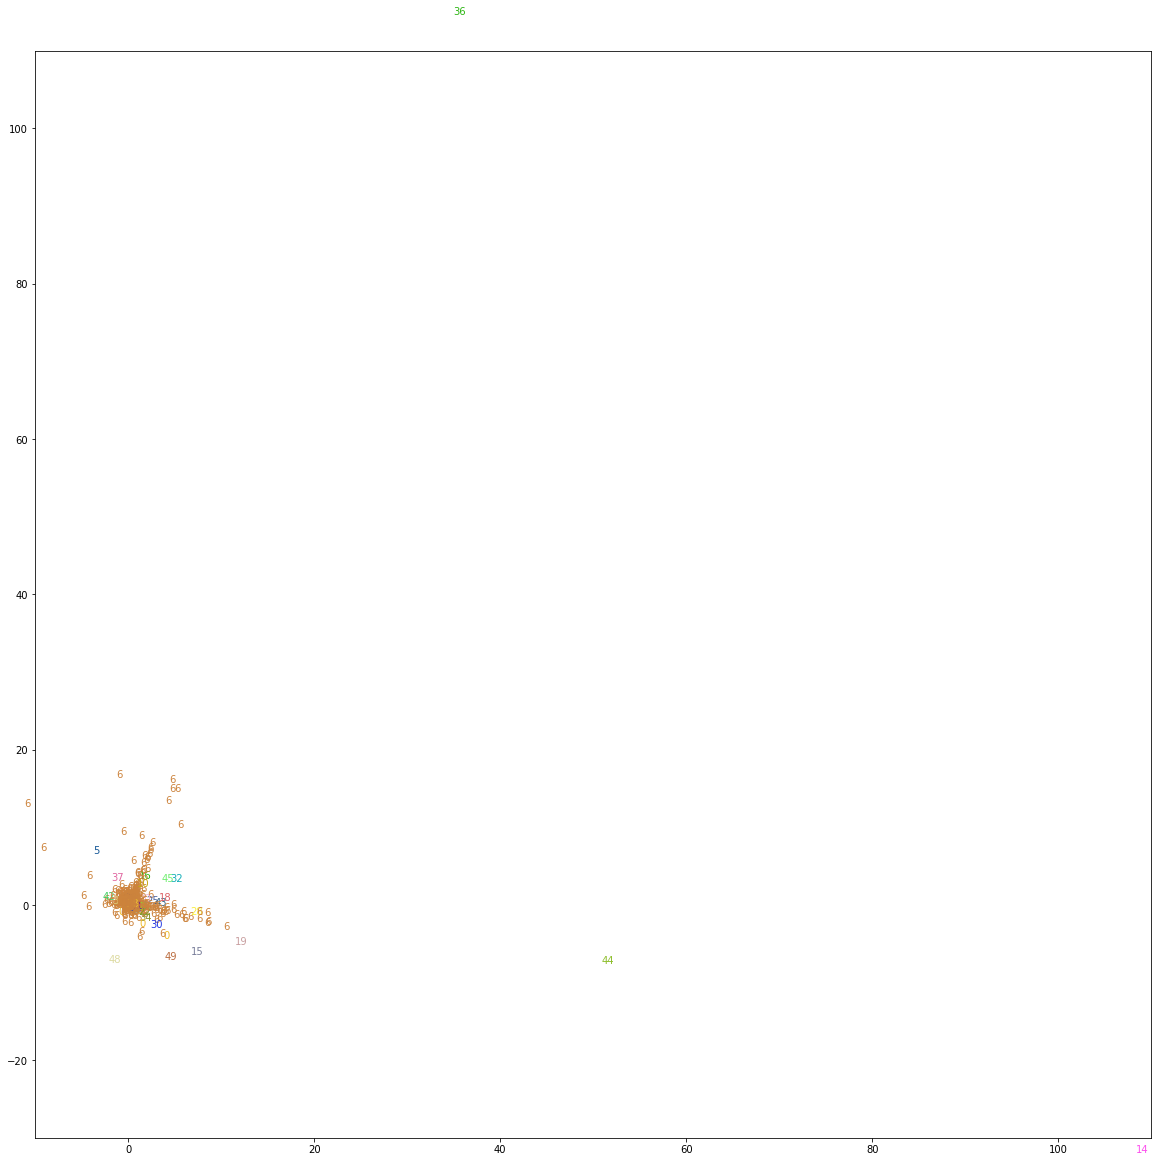

Silhouette Coefficient: -0.352


In [ ]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise, selon la méthode donnée dans le coup de pouce :
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], myclust.labels_[i],
            color=color[myclust.labels_[i]] ) #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,19,1,1,1,1,1,3409,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Classification supervisée

In [ ]:
tfidf

,aa,aarrggbb,abandon,abbrevi,abl,absolut,abstract,abus,academ,acc,acceleromet,accept,access,accessor,accident,accord,accoss,account,accountcontrol,accross,accumul,acid,across,action,actioncontrol,actionlink,actionresult,actionsheet,activ,activerecord,activex,actual,ad,add,addday,address,addslash,adjust,admin,advanc,...,worri,wors,worth,would,wpf,wrap,writabl,write,writeabl,writefil,writeln,written,wrong,wysiwyg,x,xhtml,xml,xp,xsd,xsl,xslt,xsltproc,xx,xxx,xyz,ye,year,yet,yield,yyyi,z,zcat,zehut,zero,zip,ziparch,zoom,ß,tags,cluster
1023055,0.336032,0.328769,0.347242,0.332249,0.236118,0.422659,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,vim,6
2177008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.512336,1.369897,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,ruby,6
368947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047674,0.05331,0.087966,0.087966,0.045013,0.070102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,.net,6
488240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124765,0.00000,0.000000,0.000000,0.000000,0.000000,0.138065,0.181217,0.108639,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,javascript,6
630434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090577,0.148554,0.252389,0.113477,0.120767,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,jquery,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.343279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,html,6
460115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit(tfidf.tags)
tfidf['lbl_tag'] = lbl_tag.transform(tfidf.tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf.iloc[:, :-2], tfidf.lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

ValueError: ignored

In [ ]:
gs = KNeighborsClassifier(n_neighbors=50)

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

plt.figure(figsize=(50, 50))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = metrics.plot_confusion_matrix(gs, X_test_scaled, y_test,
                                            # display_labels=class_names,
                                            cmap=plt.cm.Blues, \
                                            normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
plt.show()
print()

### Titres + détails

In [ ]:
coef = 1

dict_TFIDF_q = defaultdict(dict)
dict_TFIDF_b = defaultdict(dict)
dict_TFIDF = defaultdict(dict)

for i, v in dict_TF_q.items():
    for w, c in v.items():
        dict_TFIDF_q[i][w] = coef * c * dict_IDF_q[i][w]
for i, v in dict_TF_b.items():
    for w, c in v.items():
        dict_TFIDF_b[i][w] = (1 - coef) * c * dict_IDF_b[i][w]

for i in source.keys():
    for w in dict_corpus.keys():
        dict_TFIDF[i][w] = dict_TFIDF_q[i].get(w, 0) + dict_TFIDF_b[i].get(w, 0)

tfidf = pd.DataFrame(dict_TFIDF).T
tfidf.columns = tfidf.columns.sort_values() 
tfidf.head()

A des fins d'analyse, j'ajoute les tags correspondants à TFIDF

In [ ]:
tagnwords = defaultdict(list)

for i, j in tfidf.iterrows():
    tfidf.loc[i, 'tags'] = source[i][2]
    for col in tfidf.columns[:-1].values:
        if tfidf.loc[i, col] != 0:
            tagnwords[', '.join(source[i][2])].append(col)

#tagnwords['c#']

# Clustering

In [ ]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

X = tfidf.iloc[:, :-1].values

# On commence par réduire la dimension des données avec tSNE. On scale d’abord les données :
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Puis on applique tSNE aux données scalées :
tsne = manifold.TSNE(n_components=2, init='pca')
X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise, selon la méthode donnée dans le coup de pouce :
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], myclust.labels_[i],
            color=color[myclust.labels_[i]] ) #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

In [ ]:
tfidf.head()

In [ ]:
tfidf[(tfidf.cluster == 0)]

# LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 50

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(tfidf.iloc[:, :-2])

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tfidf.columns[:-1], no_top_words)

## Classification supervisée

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit(tfidf.tags)
tfidf['lbl_tag'] = lbl_tag.transform(tfidf.tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf.iloc[:, :-3], tfidf.lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

In [ ]:
gs = KNeighborsClassifier(n_neighbors=50)

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

plt.figure(figsize=(15, 15))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = metrics.plot_confusion_matrix(gs, X_test_scaled, y_test,
                                            # display_labels=class_names,
                                            cmap=plt.cm.Blues, \
                                            normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
plt.show()
print()